In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
diagnoses = pd.read_csv('DIAGNOSES_ICD.csv')
patients = pd.read_csv('PATIENTS.csv')
admissions = pd.read_csv('ADMISSIONS.csv')
procedures = pd.read_csv('PROCEDURES_ICD.csv')

## Feature Engineering for Procedure Code Categories

In [3]:
# Create a record column for the ICD Procedure Categories 
procedures['RECODE'] = procedures['ICD9_CODE'].astype(str)
procedures['RECODE'] = procedures['RECODE'][~procedures['RECODE'].str.contains("[a-zA-Z]").fillna(False)]
procedures['RECODE'] = procedures['RECODE'].fillna('99')

In [4]:
procedures['RECODE'] = procedures['RECODE'].str.slice(start=0, stop=2, step=1)
procedures['RECODE'] = procedures['RECODE'].astype(int)

procedures.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,RECODE
0,944,62641,154460,3,3404,34
1,945,2592,130856,1,9671,96
2,946,2592,130856,2,3893,38
3,947,55357,119355,1,9672,96
4,948,55357,119355,2,331,33


In [5]:
# IC9 Procedure Categories

icd_chapters = [(0, 1), (1, 6), (6, 8), (8, 17), (18, 21), (21, 30), (30, 35),
                (35, 40), (40, 42), (42, 55), (55, 60), (60, 65), (65, 72),
                (72, 76), (76, 85), (85, 87), (87, 100)]

procedure_dict = {0: 'unclassified', 1: 'nervous system', 2: 'endocrine', 3: 'eye', 4: 'ear', 5: 'nose/mouth/pharynx',
                  6: 'respiratory', 7: 'cardiovascular', 8: 'hemic/lymphatic', 9: 'digestive',
                  10: 'urinary', 11: 'male genitals', 12: 'female genitals', 13: 'obstetrics', 
                  14: 'muscloskeletal', 15: 'integumentary', 16: 'misc diagnostic/therapeutic'}

# Recode by their respective ICD9 Procedure Categories
for idx, chapter in enumerate(icd_chapters):
    procedures['RECODE'] = np.where(procedures['RECODE'].between(chapter[0], chapter[1]), idx, procedures['RECODE'])

procedures['RECODE'] = procedures['RECODE'].map(procedure_dict)

procedures.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,RECODE
0,944,62641,154460,3,3404,respiratory
1,945,2592,130856,1,9671,misc diagnostic/therapeutic
2,946,2592,130856,2,3893,cardiovascular
3,947,55357,119355,1,9672,misc diagnostic/therapeutic
4,948,55357,119355,2,331,respiratory


In [6]:
procedures['RECODE'].value_counts()

RECODE
misc diagnostic/therapeutic    93295
cardiovascular                 69107
digestive                      25408
respiratory                    21859
muscloskeletal                 10064
eye                             4411
integumentary                   4386
male genitals                   2869
nose/mouth/pharynx              2288
hemic/lymphatic                 2231
female genitals                 1732
urinary                         1090
ear                              849
obstetrics                       506
Name: count, dtype: int64

In [7]:
# Create procedure list per admission

procedures_list = procedures.groupby('HADM_ID')['RECODE'].apply(list).reset_index()
procedures_list = procedures_list.rename(columns={'RECODE': 'PROCEDURE_LIST'})

procedures_list.head()

,HADM_ID,PROCEDURE_LIST
0,100003,"[digestive, misc diagnostic/therapeutic, misc ..."
1,100006,"[misc diagnostic/therapeutic, misc diagnostic/..."
2,100007,"[digestive, digestive]"
3,100009,"[cardiovascular, cardiovascular, cardiovascula..."
4,100010,"[digestive, digestive, cardiovascular]"


In [8]:
# Create a Dummy Matrix for the ICD9 Procedure Categories
procedures_matrix = pd.get_dummies(procedures_list['PROCEDURE_LIST'].apply(pd.Series).stack()).groupby(level=0).sum()

# Add suffix to the column names
procedures_matrix = procedures_matrix.add_suffix('_px')
procedures_matrix.head()

,cardiovascular_px,digestive_px,ear_px,eye_px,female genitals_px,hemic/lymphatic_px,integumentary_px,male genitals_px,misc diagnostic/therapeutic_px,muscloskeletal_px,nose/mouth/pharynx_px,obstetrics_px,respiratory_px,urinary_px
0,1,1,0,0,0,0,0,0,2,0,0,0,0,0
1,0,0,0,0,0,0,0,0,2,0,0,0,0,0
2,0,2,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,2,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
# Make sure that the dummmy sums are integers 
procedures_matrix = procedures_matrix.astype(int)

# Join in HADM_ID to the procedures_matrix
procedures_matrix = procedures_matrix.join(procedures_list['HADM_ID'], how='left')

procedures_matrix.head()

,cardiovascular_px,digestive_px,ear_px,eye_px,female genitals_px,hemic/lymphatic_px,integumentary_px,male genitals_px,misc diagnostic/therapeutic_px,muscloskeletal_px,nose/mouth/pharynx_px,obstetrics_px,respiratory_px,urinary_px,HADM_ID
0,1,1,0,0,0,0,0,0,2,0,0,0,0,0,100003
1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,100006
2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,100007
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,100009
4,1,2,0,0,0,0,0,0,0,0,0,0,0,0,100010


## Feature Engineering for Diagnosis Code Categories

In [10]:
diagnoses['RECODE'] = diagnoses['ICD9_CODE'].astype(str)
diagnoses['RECODE'] = diagnoses['RECODE'][~diagnoses['RECODE'].str.contains("[a-zA-Z]").fillna(False)]
diagnoses['RECODE'] = diagnoses['RECODE'].fillna('999')

In [11]:
diagnoses['RECODE'] = diagnoses['RECODE'].str.slice(start=0, stop=3, step=1)
diagnoses['RECODE'] = diagnoses['RECODE'].astype(int)

diagnoses.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,RECODE
0,1297,109,172335,1.0,40301,403
1,1298,109,172335,2.0,486,486
2,1299,109,172335,3.0,58281,582
3,1300,109,172335,4.0,5855,585
4,1301,109,172335,5.0,4254,425


In [12]:
icd_chapters = [(0, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390), (390, 460),
                (460, 520), (520, 580), (580, 630), (630, 680), (680, 710), (710, 740),
                (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

diagnosis_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood', 4: 'mental', 5: 'nervous',
                    6: 'circulatory', 7: 'respiratory', 8: 'digestive', 9: 'genitourinary',
                    10: 'pregnancy', 11: 'skin', 12: 'musculoskeletal', 13: 'congenital', 14: 'perinatal',
                    15: 'ill-defined', 16: 'injury', 17: 'other'}

for idx, chapter in enumerate(icd_chapters):
    diagnoses['RECODE'] = np.where(diagnoses['RECODE'].between(chapter[0], chapter[1]), idx, diagnoses['RECODE'])

diagnoses['RECODE'] = diagnoses['RECODE'].map(diagnosis_dict)

diagnoses.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,RECODE
0,1297,109,172335,1.0,40301,circulatory
1,1298,109,172335,2.0,486,respiratory
2,1299,109,172335,3.0,58281,genitourinary
3,1300,109,172335,4.0,5855,genitourinary
4,1301,109,172335,5.0,4254,circulatory


In [13]:
diagnoses['RECODE'].value_counts()

RECODE
circulatory        140258
injury             140077
endocrine           71711
respiratory         44835
digestive           38586
genitourinary       32796
perinatal           25905
mental              24725
ill-defined         24027
blood               23340
nervous             23214
infectious          20268
neoplasms           14306
musculoskeletal     12860
skin                 9312
congenital           4163
pregnancy             664
Name: count, dtype: int64

In [14]:
diagnosis_list = diagnoses.groupby('HADM_ID')['RECODE'].apply(list).reset_index()
diagnosis_list = diagnosis_list.rename(columns={'RECODE': 'DIAGNOSIS_LIST'})

diagnosis_list.head()

,HADM_ID,DIAGNOSIS_LIST
0,100001,"[endocrine, nervous, genitourinary, digestive,..."
1,100003,"[digestive, blood, infectious, digestive, circ..."
2,100006,"[respiratory, respiratory, respiratory, neopla..."
3,100007,"[digestive, digestive, injury, respiratory, ci..."
4,100009,"[circulatory, injury, circulatory, endocrine, ..."


In [15]:
diagnosis_matrix = pd.get_dummies(diagnosis_list['DIAGNOSIS_LIST'].apply(pd.Series).stack()).groupby(level=0).sum()
diagnosis_matrix = diagnosis_matrix.add_suffix('_dx')
diagnosis_matrix = diagnosis_matrix.astype(int)
diagnosis_matrix = diagnosis_matrix.join(diagnosis_list['HADM_ID'], how='left')

diagnosis_matrix.head()

,blood_dx,circulatory_dx,congenital_dx,digestive_dx,endocrine_dx,genitourinary_dx,ill-defined_dx,infectious_dx,injury_dx,mental_dx,musculoskeletal_dx,neoplasms_dx,nervous_dx,perinatal_dx,pregnancy_dx,respiratory_dx,skin_dx,HADM_ID
0,0,2,0,2,5,2,0,0,2,0,0,0,2,0,0,0,1,100001
1,1,2,0,4,0,0,1,1,0,0,0,0,0,0,0,0,0,100003
2,0,0,0,0,1,0,1,0,2,1,0,1,0,0,0,3,0,100006
3,0,1,0,2,0,0,0,0,1,0,0,0,0,0,0,1,0,100007
4,1,7,0,0,3,0,0,0,7,0,0,0,0,0,0,0,0,100009


In [16]:
# Merge the diagnosis and procedure matrices
combined_matrix = pd.merge(diagnosis_matrix, procedures_matrix, on='HADM_ID', how='outer')

# Show all columns
pd.set_option('display.max_columns', None)

# Fill NaN values with 0
combined_matrix = combined_matrix.fillna(0)

# Convert all columns to integers
combined_matrix = combined_matrix.astype(int)

combined_matrix.head()

,blood_dx,circulatory_dx,congenital_dx,digestive_dx,endocrine_dx,genitourinary_dx,ill-defined_dx,infectious_dx,injury_dx,mental_dx,musculoskeletal_dx,neoplasms_dx,nervous_dx,perinatal_dx,pregnancy_dx,respiratory_dx,skin_dx,HADM_ID,cardiovascular_px,digestive_px,ear_px,eye_px,female genitals_px,hemic/lymphatic_px,integumentary_px,male genitals_px,misc diagnostic/therapeutic_px,muscloskeletal_px,nose/mouth/pharynx_px,obstetrics_px,respiratory_px,urinary_px
0,0,2,0,2,5,2,0,0,2,0,0,0,2,0,0,0,1,100001,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,2,0,4,0,0,1,1,0,0,0,0,0,0,0,0,0,100003,1,1,0,0,0,0,0,0,2,0,0,0,0,0
2,0,0,0,0,1,0,1,0,2,1,0,1,0,0,0,3,0,100006,0,0,0,0,0,0,0,0,2,0,0,0,0,0
3,0,1,0,2,0,0,0,0,1,0,0,0,0,0,0,1,0,100007,0,2,0,0,0,0,0,0,0,0,0,0,0,0
4,1,7,0,0,3,0,0,0,7,0,0,0,0,0,0,0,0,100009,4,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
# Merge the procedures_matrix and admissions dataframes
merged = pd.merge(admissions, combined_matrix, on='HADM_ID')

merged.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,blood_dx,circulatory_dx,congenital_dx,digestive_dx,endocrine_dx,genitourinary_dx,ill-defined_dx,infectious_dx,injury_dx,mental_dx,musculoskeletal_dx,neoplasms_dx,nervous_dx,perinatal_dx,pregnancy_dx,respiratory_dx,skin_dx,cardiovascular_px,digestive_px,ear_px,eye_px,female genitals_px,hemic/lymphatic_px,integumentary_px,male genitals_px,misc diagnostic/therapeutic_px,muscloskeletal_px,nose/mouth/pharynx_px,obstetrics_px,respiratory_px,urinary_px
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,0,1,0,0,0,0,0,0,4,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,0,4,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,3,0,0,0,0,0,0,0,4,0,0,0,0,0
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1,0,2,0,0,2,0,0,0,3,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1,0,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,3,0,0,0,0,0
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,5,0,0,0,0,0


In [18]:
# Merge the merged and patients dataframes
merged = pd.merge(merged, patients, on='SUBJECT_ID')

merged.head()

,ROW_ID_x,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,blood_dx,circulatory_dx,congenital_dx,digestive_dx,endocrine_dx,genitourinary_dx,ill-defined_dx,infectious_dx,injury_dx,mental_dx,musculoskeletal_dx,neoplasms_dx,nervous_dx,perinatal_dx,pregnancy_dx,respiratory_dx,skin_dx,cardiovascular_px,digestive_px,ear_px,eye_px,female genitals_px,hemic/lymphatic_px,integumentary_px,male genitals_px,misc diagnostic/therapeutic_px,muscloskeletal_px,nose/mouth/pharynx_px,obstetrics_px,respiratory_px,urinary_px,ROW_ID_y,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,0,1,0,0,0,0,0,0,4,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,19,F,2131-05-07 00:00:00,NaN,NaN,NaN,0
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,0,4,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,3,0,0,0,0,0,0,0,4,0,0,0,0,0,20,M,2082-07-17 00:00:00,NaN,NaN,NaN,0
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1,0,2,0,0,2,0,0,0,3,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,20,M,2082-07-17 00:00:00,NaN,NaN,NaN,0
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1,0,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,3,0,0,0,0,0,21,M,2100-05-31 00:00:00,NaN,NaN,NaN,0
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,5,0,0,0,0,0,22,M,2101-11-21 00:00:00,NaN,NaN,NaN,0


## Feature Engineering of Age and LOS

In [ ]:
# Calculate the age of the patient at the time of admission and length of stay

def calculate_age(dob, admittime):
    dob = datetime.strptime(str(dob), "%Y-%m-%d %H:%M:%S")
    admit = datetime.strptime(str(admittime), '%Y-%m-%d %H:%M:%S')
    return (admit - dob).days // 365

def calculate_los(admittime, dischtime):
    admit = datetime.strptime(str(admittime), '%Y-%m-%d %H:%M:%S')
    disch = datetime.strptime(str(dischtime), '%Y-%m-%d %H:%M:%S')
    return (disch - admit).days

merged['age'] = merged.apply(lambda x: calculate_age(x['DOB'], x['ADMITTIME']), axis=1)

merged['los'] = merged.apply(lambda x: calculate_los(x['ADMITTIME'], x['DISCHTIME']), axis=1)

merged.head()

,ROW_ID_x,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,blood_dx,circulatory_dx,congenital_dx,digestive_dx,endocrine_dx,genitourinary_dx,ill-defined_dx,infectious_dx,injury_dx,mental_dx,musculoskeletal_dx,neoplasms_dx,nervous_dx,perinatal_dx,pregnancy_dx,respiratory_dx,skin_dx,cardiovascular_px,digestive_px,ear_px,eye_px,female genitals_px,hemic/lymphatic_px,integumentary_px,male genitals_px,misc diagnostic/therapeutic_px,muscloskeletal_px,nose/mouth/pharynx_px,obstetrics_px,respiratory_px,urinary_px,ROW_ID_y,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,age,los
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,0,1,0,0,0,0,0,0,4,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,19,F,2131-05-07 00:00:00,NaN,NaN,NaN,0,64,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,0,4,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,3,0,0,0,0,0,0,0,4,0,0,0,0,0,20,M,2082-07-17 00:00:00,NaN,NaN,NaN,0,71,5
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1,0,2,0,0,2,0,0,0,3,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,20,M,2082-07-17 00:00:00,NaN,NaN,NaN,0,75,6
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1,0,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,3,0,0,0,0,0,21,M,2100-05-31 00:00:00,NaN,NaN,NaN,0,39,2
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,5,0,0,0,0,0,22,M,2101-11-21 00:00:00,NaN,NaN,NaN,0,58,3


In [ ]:
# Remove anyone older than 120
merged = merged[merged['age'] < 120]

In [21]:
# Drop columns that are not needed
merged = merged.drop(['ROW_ID_x', 'ROW_ID_y', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'EDREGTIME', 'EDOUTTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'HAS_CHARTEVENTS_DATA', 'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN', 'EXPIRE_FLAG'], axis=1)
merged.head()

,SUBJECT_ID,HADM_ID,ETHNICITY,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,blood_dx,circulatory_dx,congenital_dx,digestive_dx,endocrine_dx,genitourinary_dx,ill-defined_dx,infectious_dx,injury_dx,mental_dx,musculoskeletal_dx,neoplasms_dx,nervous_dx,perinatal_dx,pregnancy_dx,respiratory_dx,skin_dx,cardiovascular_px,digestive_px,ear_px,eye_px,female genitals_px,hemic/lymphatic_px,integumentary_px,male genitals_px,misc diagnostic/therapeutic_px,muscloskeletal_px,nose/mouth/pharynx_px,obstetrics_px,respiratory_px,urinary_px,GENDER,age,los
0,22,165315,WHITE,BENZODIAZEPINE OVERDOSE,0,0,1,0,0,0,0,0,0,4,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,F,64,1
1,23,152223,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,0,4,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,3,0,0,0,0,0,0,0,4,0,0,0,0,0,M,71,5
2,23,124321,WHITE,BRAIN MASS,0,0,2,0,0,2,0,0,0,3,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,M,75,6
3,24,161859,WHITE,INTERIOR MYOCARDIAL INFARCTION,0,0,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,3,0,0,0,0,0,M,39,2
4,25,129635,WHITE,ACUTE CORONARY SYNDROME,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,5,0,0,0,0,0,M,58,3


## Feature Engineering of Ethnicity, Hemorrhage Location, and Gender Categories

In [22]:
# Create Ethnicity Categories 
merged['ETHNICITY'].replace(regex=r'^ASIAN.*', value='asian', inplace=True)
merged['ETHNICITY'].replace(regex=r'^WHITE.*', value='white', inplace=True)
merged['ETHNICITY'].replace(regex=r'^PORTUGUESE.*', value='hispanic/latino', inplace=True)
merged['ETHNICITY'].replace(regex=r'^HISPANIC.*', value='hispanic/latino', inplace=True)
merged['ETHNICITY'].replace(regex=r'^BLACK.*', value='black', inplace=True)
merged['ETHNICITY'].replace(regex=r'.*AMERICAN.*', value='unknown/other', inplace=True)
merged['ETHNICITY'].replace(regex=r'.*CARIBBEAN.*', value='unknown/other', inplace=True)
merged['ETHNICITY'].replace(regex=r'.*PACIFIC ISLANDER.*', value='unknown/other', inplace=True)
merged['ETHNICITY'].replace(regex=r'.*MIDDLE EASTERN.*', value='asian', inplace=True)
merged['ETHNICITY'].replace(regex=r'.*MULTI.*', value='unknown/other', inplace=True)
merged['ETHNICITY'].replace(['UNKNOWN/NOT SPECIFIED', 'OTHER', 'UNABLE TO OBTAIN', 'PATIENT DECLINED TO ANSWER'], value='unknown/other', inplace=True)

merged['ETHNICITY'].value_counts()

C:\Users\alejm\AppData\Local\Temp\ipykernel_12740\151483324.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged['ETHNICITY'].replace(regex=r'^ASIAN.*', value='asian', inplace=True)
C:\Users\alejm\AppData\Local\Temp\ipykernel_12740\151483324.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always be

ETHNICITY
white              39135
unknown/other       7412
black               5646
hispanic/latino     2173
asian               1994
Name: count, dtype: int64

In [23]:
# Create dummy variables for Ethnicity
ethnicity_dummies = pd.get_dummies(merged['ETHNICITY'])

# Convert the dummy variables to integers
ethnicity_dummies = ethnicity_dummies.astype(int)

# Merge the dummary variables with the merged dataframe
merged = pd.concat([merged, ethnicity_dummies], axis=1)

# Drop the ethnicity column
merged = merged.drop('ETHNICITY', axis=1)

merged.head()


,SUBJECT_ID,HADM_ID,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,blood_dx,circulatory_dx,congenital_dx,digestive_dx,endocrine_dx,genitourinary_dx,ill-defined_dx,infectious_dx,injury_dx,mental_dx,musculoskeletal_dx,neoplasms_dx,nervous_dx,perinatal_dx,pregnancy_dx,respiratory_dx,skin_dx,cardiovascular_px,digestive_px,ear_px,eye_px,female genitals_px,hemic/lymphatic_px,integumentary_px,male genitals_px,misc diagnostic/therapeutic_px,muscloskeletal_px,nose/mouth/pharynx_px,obstetrics_px,respiratory_px,urinary_px,GENDER,age,los,asian,black,hispanic/latino,unknown/other,white
0,22,165315,BENZODIAZEPINE OVERDOSE,0,0,1,0,0,0,0,0,0,4,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,F,64,1,0,0,0,0,1
1,23,152223,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,0,4,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,3,0,0,0,0,0,0,0,4,0,0,0,0,0,M,71,5,0,0,0,0,1
2,23,124321,BRAIN MASS,0,0,2,0,0,2,0,0,0,3,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,M,75,6,0,0,0,0,1
3,24,161859,INTERIOR MYOCARDIAL INFARCTION,0,0,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,3,0,0,0,0,0,M,39,2,0,0,0,0,1
4,25,129635,ACUTE CORONARY SYNDROME,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,5,0,0,0,0,0,M,58,3,0,0,0,0,1


In [24]:
# Create dummy variables for Gender
gender_dummies = pd.get_dummies(merged['GENDER'])

# Convert the dummy variables to integers
gender_dummies = gender_dummies.astype(int)

# Merge the dummary variables with the merged dataframe
merged = pd.concat([merged, gender_dummies], axis=1)

# Drop the gender column
merged = merged.drop('GENDER', axis=1)

merged.head()

,SUBJECT_ID,HADM_ID,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,blood_dx,circulatory_dx,congenital_dx,digestive_dx,endocrine_dx,genitourinary_dx,ill-defined_dx,infectious_dx,injury_dx,mental_dx,musculoskeletal_dx,neoplasms_dx,nervous_dx,perinatal_dx,pregnancy_dx,respiratory_dx,skin_dx,cardiovascular_px,digestive_px,ear_px,eye_px,female genitals_px,hemic/lymphatic_px,integumentary_px,male genitals_px,misc diagnostic/therapeutic_px,muscloskeletal_px,nose/mouth/pharynx_px,obstetrics_px,respiratory_px,urinary_px,age,los,asian,black,hispanic/latino,unknown/other,white,F,M
0,22,165315,BENZODIAZEPINE OVERDOSE,0,0,1,0,0,0,0,0,0,4,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,64,1,0,0,0,0,1,1,0
1,23,152223,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,0,4,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,3,0,0,0,0,0,0,0,4,0,0,0,0,0,71,5,0,0,0,0,1,0,1
2,23,124321,BRAIN MASS,0,0,2,0,0,2,0,0,0,3,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,75,6,0,0,0,0,1,0,1
3,24,161859,INTERIOR MYOCARDIAL INFARCTION,0,0,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,3,0,0,0,0,0,39,2,0,0,0,0,1,0,1
4,25,129635,ACUTE CORONARY SYNDROME,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,5,0,0,0,0,0,58,3,0,0,0,0,1,0,1


In [25]:
# Narrow our admissions to strictly brain bleeds
brain_bleeds = merged[merged['DIAGNOSIS'].str.contains(r'(?:INTRACRANIAL|SUBARACHNOID|SUBDURAL|INTRACEREBRAL|INTRAVENTRICULAR|INTRAPARENCHYMAL|EPIDURAL|CEREBELLAR) HEMORRHAGE', case=False, na=False)]

In [26]:
# Set display options to show all rows
pd.set_option('display.max_rows', None)

# Show all value counts for the diagnosis
brain_bleeds['DIAGNOSIS'].value_counts()

DIAGNOSIS
INTRACRANIAL HEMORRHAGE                                                        665
SUBARACHNOID HEMORRHAGE                                                        428
INTRAPARENCHYMAL HEMORRHAGE                                                     80
SUBDURAL HEMORRHAGE                                                             77
INTRACRANIAL HEMORRHAGE;TELEMETRY                                               29
INTRACEREBRAL HEMORRHAGE                                                        19
SUBARACHNOID HEMORRHAGE;TELEMETRY                                               16
INTRAVENTRICULAR HEMORRHAGE                                                      9
CEREBELLAR HEMORRHAGE                                                            8
SUBARACHNOID HEMORRHAGE;ACUTE SUBDURAL HEMATOMA                                  8
INTRAPARENCHYMAL HEMORRHAGE;TELEMETRY                                            6
EPIDURAL HEMORRHAGE                                                          

In [27]:
brain_bleeds['DIAGNOSIS'].replace(regex=r'.*INTRACRANIAL HEMORRHAGE.*', value='intracranial', inplace=True)
brain_bleeds['DIAGNOSIS'].replace(regex=r'.*SUBARACHNOID HEMORRHAGE.*', value='subarachnoid', inplace=True)
brain_bleeds['DIAGNOSIS'].replace(regex=r'.*SUBDURAL HEMORRHAGE.*', value='subdural', inplace=True)
brain_bleeds['DIAGNOSIS'].replace(regex=r'.*INTRACEREBRAL HEMORRHAGE.*', value='intracerebral', inplace=True)
brain_bleeds['DIAGNOSIS'].replace(regex=r'.*INTRAVENTRICULAR HEMORRHAGE.*', value='intraventricular', inplace=True)
brain_bleeds['DIAGNOSIS'].replace(regex=r'.*INTRAPARENCHYMAL HEMORRHAGE.*', value='intraparenchymal', inplace=True)
brain_bleeds['DIAGNOSIS'].replace(regex=r'.*EPIDURAL HEMORRHAGE.*', value='epidural', inplace=True)
brain_bleeds['DIAGNOSIS'].replace(regex=r'.*CEREBELLAR HEMORRHAGE.*', value='cerebellar', inplace=True)

brain_bleeds['DIAGNOSIS'].value_counts()

C:\Users\alejm\AppData\Local\Temp\ipykernel_12740\3400940345.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  brain_bleeds['DIAGNOSIS'].replace(regex=r'.*INTRACRANIAL HEMORRHAGE.*', value='intracranial', inplace=True)
C:\Users\alejm\AppData\Local\Temp\ipykernel_12740\3400940345.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brain_bleed

DIAGNOSIS
intracranial        755
subarachnoid        516
subdural            112
intraparenchymal     92
intracerebral        23
cerebellar            9
intraventricular      9
epidural              7
Name: count, dtype: int64

In [ ]:
#Create dummy variables for the diagnosis
diagnosis_dummies = pd.get_dummies(brain_bleeds['DIAGNOSIS'])

# Convert the dummy variables to integers
diagnosis_dummies = diagnosis_dummies.astype(int)

# Merge the dummary variables with the merged dataframe
brain_bleeds = pd.concat([brain_bleeds, diagnosis_dummies], axis=1)

# Drop the diagnosis column
brain_bleeds = brain_bleeds.drop('DIAGNOSIS', axis=1)

brain_bleeds.head()

,SUBJECT_ID,HADM_ID,HOSPITAL_EXPIRE_FLAG,blood_dx,circulatory_dx,congenital_dx,digestive_dx,endocrine_dx,genitourinary_dx,ill-defined_dx,infectious_dx,injury_dx,mental_dx,musculoskeletal_dx,neoplasms_dx,nervous_dx,perinatal_dx,pregnancy_dx,respiratory_dx,skin_dx,cardiovascular_px,digestive_px,ear_px,eye_px,female genitals_px,hemic/lymphatic_px,integumentary_px,male genitals_px,misc diagnostic/therapeutic_px,muscloskeletal_px,nose/mouth/pharynx_px,obstetrics_px,respiratory_px,urinary_px,age,los,asian,black,hispanic/latino,unknown/other,white,F,M,cerebellar,epidural,intracerebral,intracranial,intraparenchymal,intraventricular,subarachnoid,subdural
44,372,144383,0,0,1,0,0,1,0,0,0,6,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,45,7,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
70,67,155252,1,0,2,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,73,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
84,81,175016,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,85,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0
108,103,130744,0,0,2,0,0,1,0,1,0,1,0,0,2,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,60,7,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
109,103,133550,1,0,3,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0


In [29]:
# Drop the SUBJECT_ID and HADM_ID columns
brain_bleeds = brain_bleeds.drop(['SUBJECT_ID', 'HADM_ID'], axis=1)

# fill NaN values with 0
brain_bleeds = brain_bleeds.fillna(0)

brain_bleeds.head()

,HOSPITAL_EXPIRE_FLAG,blood_dx,circulatory_dx,congenital_dx,digestive_dx,endocrine_dx,genitourinary_dx,ill-defined_dx,infectious_dx,injury_dx,mental_dx,musculoskeletal_dx,neoplasms_dx,nervous_dx,perinatal_dx,pregnancy_dx,respiratory_dx,skin_dx,cardiovascular_px,digestive_px,ear_px,eye_px,female genitals_px,hemic/lymphatic_px,integumentary_px,male genitals_px,misc diagnostic/therapeutic_px,muscloskeletal_px,nose/mouth/pharynx_px,obstetrics_px,respiratory_px,urinary_px,age,los,asian,black,hispanic/latino,unknown/other,white,F,M,cerebellar,epidural,intracerebral,intracranial,intraparenchymal,intraventricular,subarachnoid,subdural
44,0,0,1,0,0,1,0,0,0,6,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,45,7,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
70,1,0,2,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,73,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
84,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,85,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0
108,0,0,2,0,0,1,0,1,0,1,0,0,2,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,60,7,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
109,1,0,3,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0


## Classifier Training & Testing

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Create Train and Test Sets

X = brain_bleeds.drop('HOSPITAL_EXPIRE_FLAG', axis=1)
Y = brain_bleeds['HOSPITAL_EXPIRE_FLAG']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [31]:
# Print the results of the split

print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', Y_train.shape)

print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', Y_test.shape)


Training Features Shape: (1218, 48)
Training Labels Shape: (1218,)
Testing Features Shape: (305, 48)
Testing Labels Shape: (305,)


In [32]:
# Normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

models = {'Logistic Regression': LogisticRegression(),
          'Random Forest': RandomForestClassifier(), 
          'AdaBoost': AdaBoostClassifier(),
          'Gradient Boosting': GradientBoostingClassifier()}

for model_name, model in models.items():
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    print(model_name)
    print('Accuracy: ', accuracy_score(Y_test, Y_pred))
    print('F1 Score: ', f1_score(Y_test, Y_pred))
    print('Confusion Matrix: \n', confusion_matrix(Y_test, Y_pred))
    print('\n')

Logistic Regression
Accuracy:  0.8262295081967214
F1 Score:  0.4752475247524752
Confusion Matrix: 
 [[228   7]
 [ 46  24]]


Random Forest
Accuracy:  0.8950819672131147
F1 Score:  0.7241379310344828
Confusion Matrix: 
 [[231   4]
 [ 28  42]]




c:\Users\alejm\miniconda3\envs\healthcareAI\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost
Accuracy:  0.8852459016393442
F1 Score:  0.7407407407407407
Confusion Matrix: 
 [[220  15]
 [ 20  50]]


Gradient Boosting
Accuracy:  0.9081967213114754
F1 Score:  0.7777777777777778
Confusion Matrix: 
 [[228   7]
 [ 21  49]]




In [43]:
# Fine tuning Gradient Boosting

from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [50, 100, 200, 300],
                'max_depth': [3, 5, 7, 9],
                'learning_rate': [0.001, 0.01, 0.1]}

grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, Y_train)

print('Best Parameters: ', grid_search.best_params_)
print('Best Score: ', grid_search.best_score_)
print('Best Estimator: ', grid_search.best_estimator_)
print('\n')

model = grid_search.best_estimator_

Best Parameters:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best Score:  0.8916256157635468
Best Estimator:  GradientBoostingClassifier(max_depth=5)




In [44]:
# Fit the model
model.fit(X_train, Y_train)

# Predict the test set
Y_pred = model.predict(X_test)

# Print the results
print('Gradient Boosting')
print('Accuracy: ', accuracy_score(Y_test, Y_pred))
print('F1 Score: ', f1_score(Y_test, Y_pred))
print('Confusion Matrix: \n', confusion_matrix(Y_test, Y_pred))

Gradient Boosting
Accuracy:  0.9114754098360656
F1 Score:  0.7874015748031497
Confusion Matrix: 
 [[228   7]
 [ 20  50]]


In [45]:
# Let's see the importance of each feature

feature_map = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['Importance']).sort_values('Importance', ascending=False)

print(feature_map)



                                Importance
los                               0.315476
misc diagnostic/therapeutic_px    0.201274
age                               0.104381
circulatory_dx                    0.045450
respiratory_dx                    0.036126
nervous_dx                        0.035187
nose/mouth/pharynx_px             0.027071
cardiovascular_px                 0.025984
injury_dx                         0.025321
digestive_px                      0.018924
neoplasms_dx                      0.013802
eye_px                            0.012888
perinatal_dx                      0.012518
digestive_dx                      0.011729
subarachnoid                      0.011693
intracranial                      0.011366
endocrine_dx                      0.010362
genitourinary_dx                  0.007361
ill-defined_dx                    0.007150
M                                 0.006968
unknown/other                     0.005011
hemic/lymphatic_px                0.004937
respiratory

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class MLP(nn.Module):
    def __init__(self, input_size, num_classes, hidden_size, dropout):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [38]:
from torch.utils.data import TensorDataset, DataLoader

# Split Training into Training and Validation
train_data, val_data, train_labels, val_labels = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Convert to PyTorch Tensors
train_data = torch.tensor(train_data, dtype=torch.float32)
train_labels = torch.tensor(train_labels.values, dtype=torch.float32).view(-1, 1)

val_data = torch.tensor(val_data, dtype=torch.float32)
val_labels = torch.tensor(val_labels.values, dtype=torch.float32).view(-1, 1)

test_data = torch.tensor(X_test, dtype=torch.float32)
test_labels = torch.tensor(Y_test.values, dtype=torch.float32).view(-1, 1)

# Create a DataLoader
train_dataset = TensorDataset(train_data, train_labels)
val_dataset = TensorDataset(val_data, val_labels)
test_dataset = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)




In [39]:
# Train the Model

def train_model(model, loss_fn, optimizer, train_loader, val_loader, num_epochs):
    epoch_metrics = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': []
    }
    for epoch in range(num_epochs):
        start = datetime.now()
        metrics = {
            'train_loss': [],
            'val_loss': [],
            'train_accuracy': [],
            'val_accuracy': []
        }
        model.train()

        for X, Y in train_loader:
            X, Y = X.to(device), Y.to(device)
            optimizer.zero_grad()
            Y_pred = model(X)
            loss = loss_fn(Y_pred, Y)
            loss.backward()
            optimizer.step()
            metrics['train_loss'].append(loss.item())
            Y_pred_class = torch.round(Y_pred)
            metrics['train_accuracy'].append((Y_pred_class == Y).sum().item() / Y.shape[0])

        model.eval()
        with torch.inference_mode():
            for X, Y in val_loader:
                X, Y = X.to(device), Y.to(device)
                Y_pred = model(X)
                loss = loss_fn(Y_pred, Y)
                metrics['val_loss'].append(loss.item())
                Y_pred_class = torch.round(Y_pred)
                metrics['val_accuracy'].append((Y_pred_class == Y).sum().item() / Y.shape[0])

        epoch_metrics['train_loss'].append(np.mean(metrics['train_loss']))
        epoch_metrics['val_loss'].append(np.mean(metrics['val_loss']))
        epoch_metrics['train_accuracy'].append(np.mean(metrics['train_accuracy']))
        epoch_metrics['val_accuracy'].append(np.mean(metrics['val_accuracy']))

        end = datetime.now()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {np.mean(metrics["train_loss"]):.4f}, Accuracy: {np.mean(metrics["train_accuracy"]):.4f}, Val Loss: {np.mean(metrics["val_loss"]):.4f}, Val Accuracy: {np.mean(metrics["val_accuracy"]):.4f}, Duration: {end-start}')

    return epoch_metrics

def graph_metrics(metrics):
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))

    ax[0].plot(metrics['train_loss'], label='Train Loss')
    ax[0].plot(metrics['val_loss'], label='Validation Loss')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(metrics['train_accuracy'], label='Train Accuracy')
    ax[1].plot(metrics['val_accuracy'], label='Validation Accuracy')
    ax[1].set_title('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.show()

# Test the Model
def evaluate_model(model, loss_fn, test_loader):
    model.eval()
    metrics = {
        'test_loss': [],
        'test_accuracy': []
    }
    all_predictions = []
    all_targets = []
    with torch.inference_mode():
        for X, Y in test_loader:
            X, Y = X.to(device), Y.to(device)
            Y_pred = model(X)
            loss = loss_fn(Y_pred, Y)
            metrics['test_loss'].append(loss.item())
            Y_pred_class = torch.round(Y_pred)
            metrics['test_accuracy'].append((Y_pred_class == Y).sum().item() / Y.shape[0])
            all_predictions.extend(Y_pred_class.cpu().detach().numpy())
            all_targets.extend(Y.cpu().detach().numpy())

    test_loss = np.mean(metrics['test_loss'])
    test_accuracy = np.mean(metrics['test_accuracy'])

    #calculate the confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)
    print('Confusion Matrix: \n', cm)

    #Plot the confusion matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Discharged', 'Deceased'], yticklabels=['Discharged', 'Deceased'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # F1 score
    precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
    recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
    f1 = 2 * (precision * recall) / (precision + recall)
    print(f'F1 Score: {f1:.4f}')
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


In [40]:
#Initialize the Model

input_size = X_train.shape[1]
num_classes = 1
hidden_size = 128
dropout = 0.3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(input_size, num_classes, hidden_size, dropout).to(device)
loss_fn = nn.BCELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 10/100, Loss: 0.3900, Accuracy: 0.8204, Val Loss: 0.4500, Val Accuracy: 0.7852, Duration: 0:00:00.394965
Epoch 20/100, Loss: 0.3111, Accuracy: 0.8696, Val Loss: 0.3924, Val Accuracy: 0.8242, Duration: 0:00:00.401213
Epoch 30/100, Loss: 0.2827, Accuracy: 0.8694, Val Loss: 0.3761, Val Accuracy: 0.8320, Duration: 0:00:00.331727
Epoch 40/100, Loss: 0.2570, Accuracy: 0.9021, Val Loss: 0.3825, Val Accuracy: 0.8438, Duration: 0:00:00.343962
Epoch 50/100, Loss: 0.2359, Accuracy: 0.9066, Val Loss: 0.3777, Val Accuracy: 0.8398, Duration: 0:00:00.340317
Epoch 60/100, Loss: 0.2208, Accuracy: 0.9150, Val Loss: 0.3784, Val Accuracy: 0.8359, Duration: 0:00:00.316805
Epoch 70/100, Loss: 0.2051, Accuracy: 0.9239, Val Loss: 0.3831, Val Accuracy: 0.8438, Duration: 0:00:00.313952
Epoch 80/100, Loss: 0.1896, Accuracy: 0.9302, Val Loss: 0.3799, Val Accuracy: 0.8359, Duration: 0:00:00.320758
Epoch 90/100, Loss: 0.1762, Accuracy: 0.9314, Val Loss: 0.3931, Val Accuracy: 0.8477, Duration: 0:00:00.307426
E

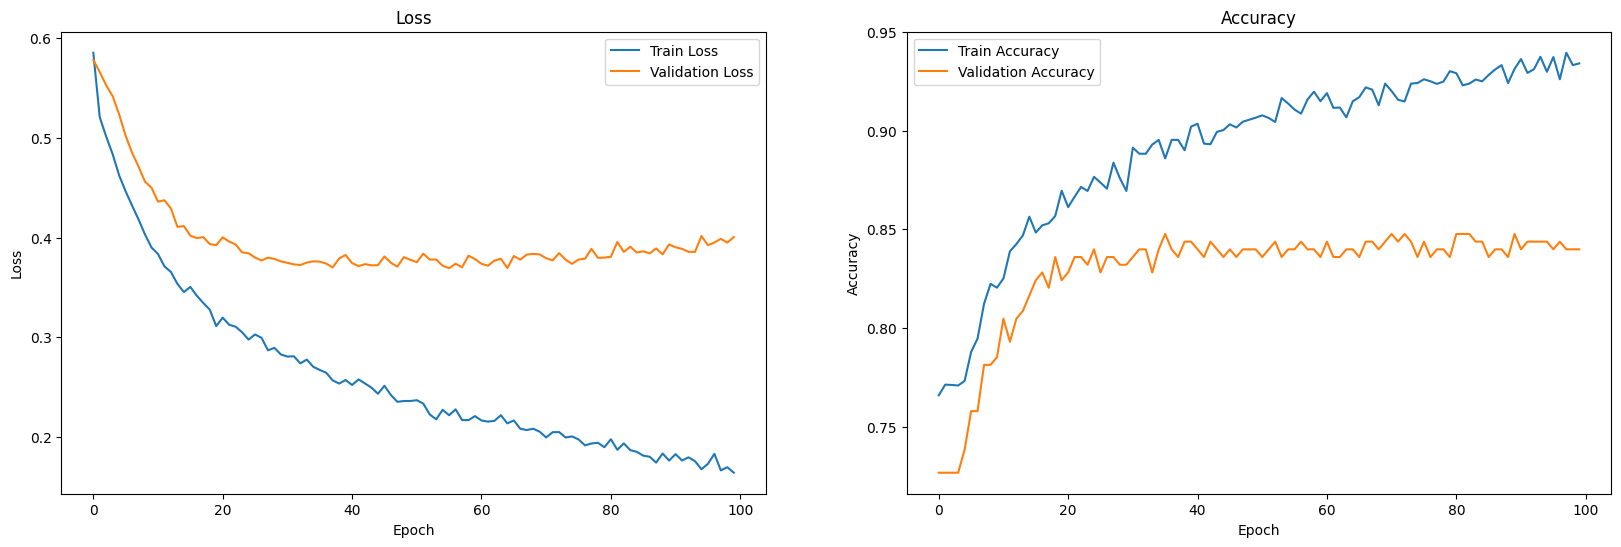

In [41]:
metrics = train_model(model, loss_fn, optimizer, train_loader, val_loader, num_epochs=100)
graph_metrics(metrics)

Confusion Matrix: 
 [[216  19]
 [ 14  56]]


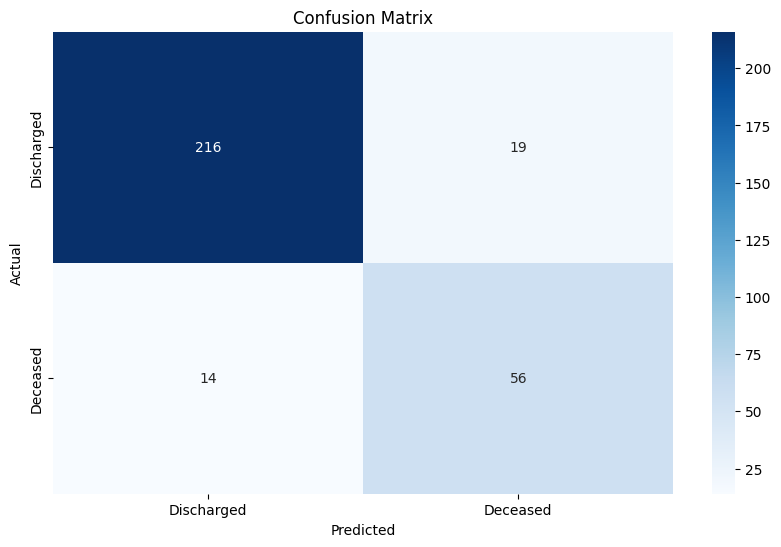

F1 Score: 0.7724
Test Loss: 0.3306, Test Accuracy: 0.8969


In [42]:
evaluate_model(model, loss_fn, test_loader)